In [2]:
import numpy as np
from sklearn.covariance import LedoitWolf, EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt


In [3]:

# Behavioral DATA
fold_g = 'F:/IRM_Marche/'
smt='ss'       
names='ap','as','boh','bh','bi','cmp','cas','cs','cb','gm','gn','gbn','mv','ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs'
label=np.loadtxt(fold_g+'label_main.txt','S12')
block=np.loadtxt(fold_g+'block_main.txt','int')
motor_region=np.fromfile('F:/IRM_Marche/masquesROI/reg_whole70_basc444asym.np','int')

# Remove data not analysed
mask_block=block==block
for x in range(label.shape[0]):
    if label[x,2]!=label[x-1,2]:
        mask_block[x]=False
    elif label[x,2]!=label[x-2,2]:
        mask_block[x]=False
c_des_out=np.logical_not(label[:,2]== b'des')
tmp_out= np.logical_and(c_des_out,mask_block)
c_rest_out=np.logical_not(label[:,0]== b'rest')
cond_out= np.logical_and(tmp_out,c_rest_out)
y=label[cond_out,2]
labels=np.unique(y)
# Prepare correlation
estimator = EmpiricalCovariance()
scaler=StandardScaler()
# Create np array
result_matrix = np.empty([len(names),motor_region.shape[0],labels.shape[0],labels.shape[0]])

#Analysis for each subject
for i,n in enumerate(sorted(names)):
    roi_name=fold_g+'mni4060/asymroi_'+smt+'_'+n+'.npz'   
    roi=np.load(roi_name)['roi'][cond_out]
    roi=roi[:,motor_region-1] 
    for j in range(motor_region.shape[0]):
        roi_j=roi[:,j]
        roi_mat=np.zeros(((y==b'imp').sum(),len(labels)))
        for z,lab in enumerate(sorted(labels)):
            roi_mat[:,z]=roi_j[y==lab]           
        roi_sc=scaler.fit_transform(roi_mat) 
        estimator.fit(roi_sc)
        matrix=estimator.covariance_ 
        result_matrix[i,j]=1-matrix


Sanity check on RDM matrices

In [4]:
result_matrix.shape

(23, 184, 4, 4)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

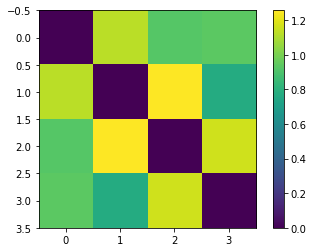

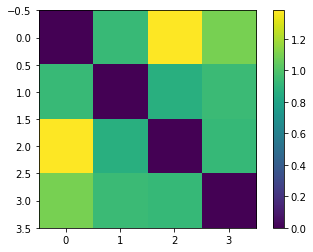

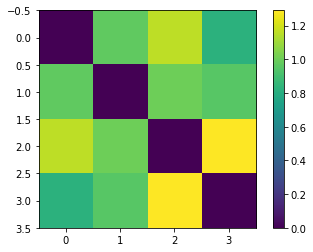

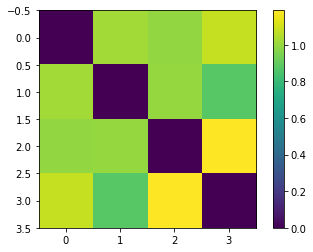

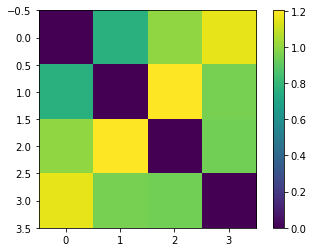

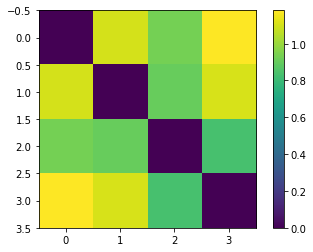

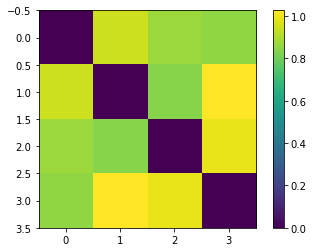

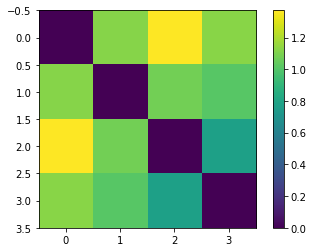

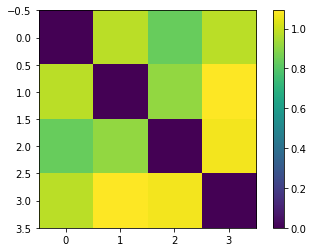

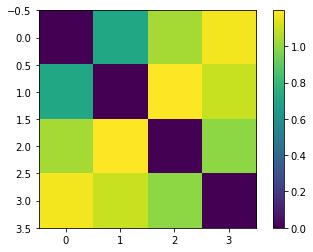

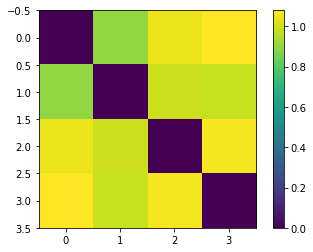

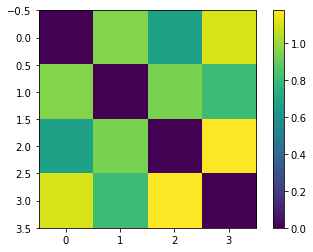

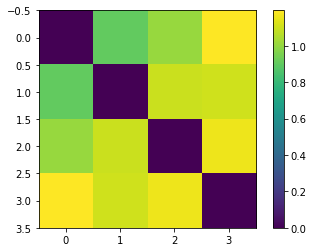

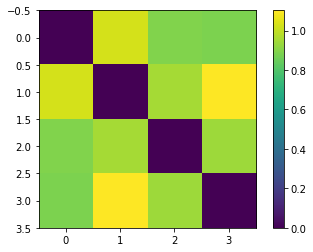

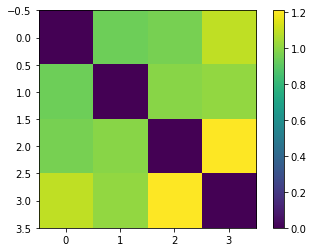

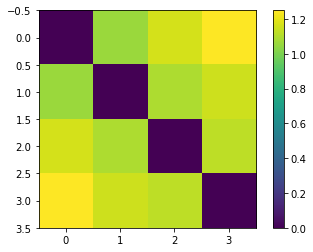

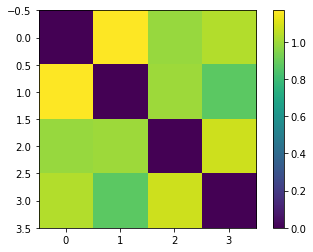

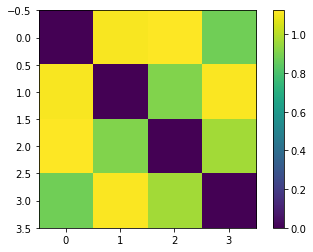

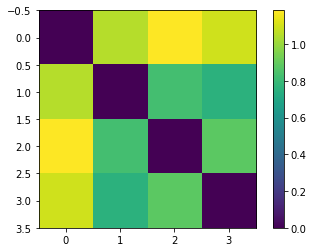

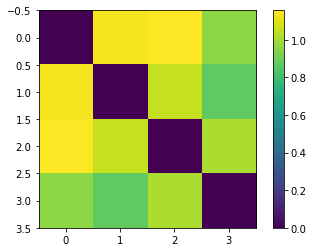

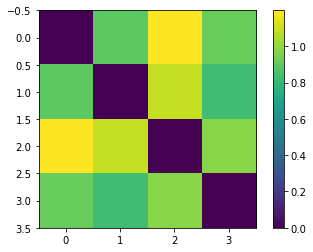

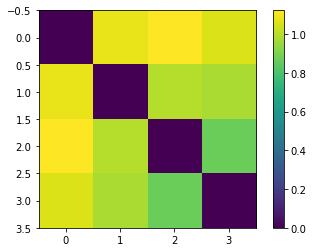

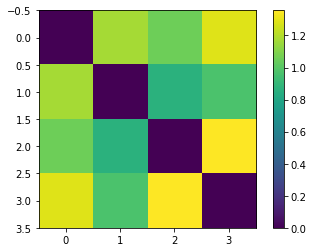

In [6]:
for c in result_matrix:
    plt.imshow(c[0],interpolation='nearest')
    plt.colorbar()
    plt.show()

First step : consider upper triangular parts of the RDM matrices

In [6]:
RDM_vectors = np.zeros((23,184,6))

for i,cursubj in enumerate(result_matrix):
    for j,curroi in enumerate(cursubj):
        
        A = np.triu(curroi,k=1)
        RDM_vectors[i,j] = A[np.triu_indices_from(A,k=1)]


PCA

Reshaping to have n_samples x n_feat

In [7]:
X = (RDM_vectors.swapaxes(1,2)).reshape((23*6,184))

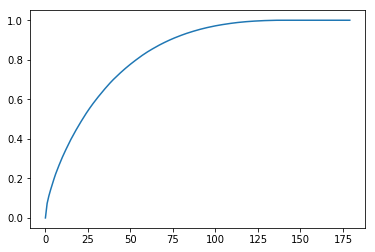

In [8]:
from sklearn.decomposition import PCA

compmax = 180

allvar = []
for k in range(compmax):
    mypca = PCA(n_components=k)
    mypca.fit(X)
    allvar.append(np.sum(mypca.explained_variance_ratio_))
    
    
plt.plot(range(compmax),allvar)

Choice of components

In [9]:
mypca = PCA(n_components=0.8)
mypca.fit(X)
print(mypca.n_components_)

54


In [10]:
X_reduc = mypca.transform(X)

In [11]:
X_reduc.shape

(138, 54)

Creating matrices back

In [12]:
RDM_vectors_reduced = (X_reduc.reshape((23,6,54))).swapaxes(1,2)

In [13]:
RDM_matrices_reduced = np.zeros((23,54,4,4))

for i,cursubj in enumerate(RDM_vectors_reduced):
    for j,curroi in enumerate(cursubj):
        temp = np.zeros((4,4))
        ind_sup = np.triu_indices(n=4,k=1)
        temp[ind_sup] = curroi
        temp = temp + temp.T
        
        RDM_matrices_reduced[i,j] = temp


Summarizing across subjects (grand average)

In [14]:
RDM_matrices_reduced_grav = RDM_matrices_reduced.mean(axis=0)

In [15]:
from sklearn.manifold import MDS

ncompmds = 2

mymds = MDS(dissimilarity='precomputed',n_components=ncompmds)

In [17]:
mds_res = mymds.fit_transform(RDM_matrices_reduced_grav[0])

In [18]:
mymds.stress_

1.1679375398360867

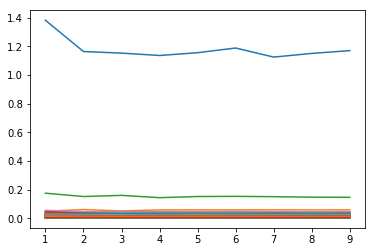

In [39]:
for reg in range(54):
    allstress = []
    for k in range(1,10):
        mymds = MDS(dissimilarity='precomputed',n_components=k)
        mymds.fit(RDM_matrices_reduced_grav[reg])
        allstress.append(mymds.stress_)
    
    plt.plot(range(1,10),allstress)

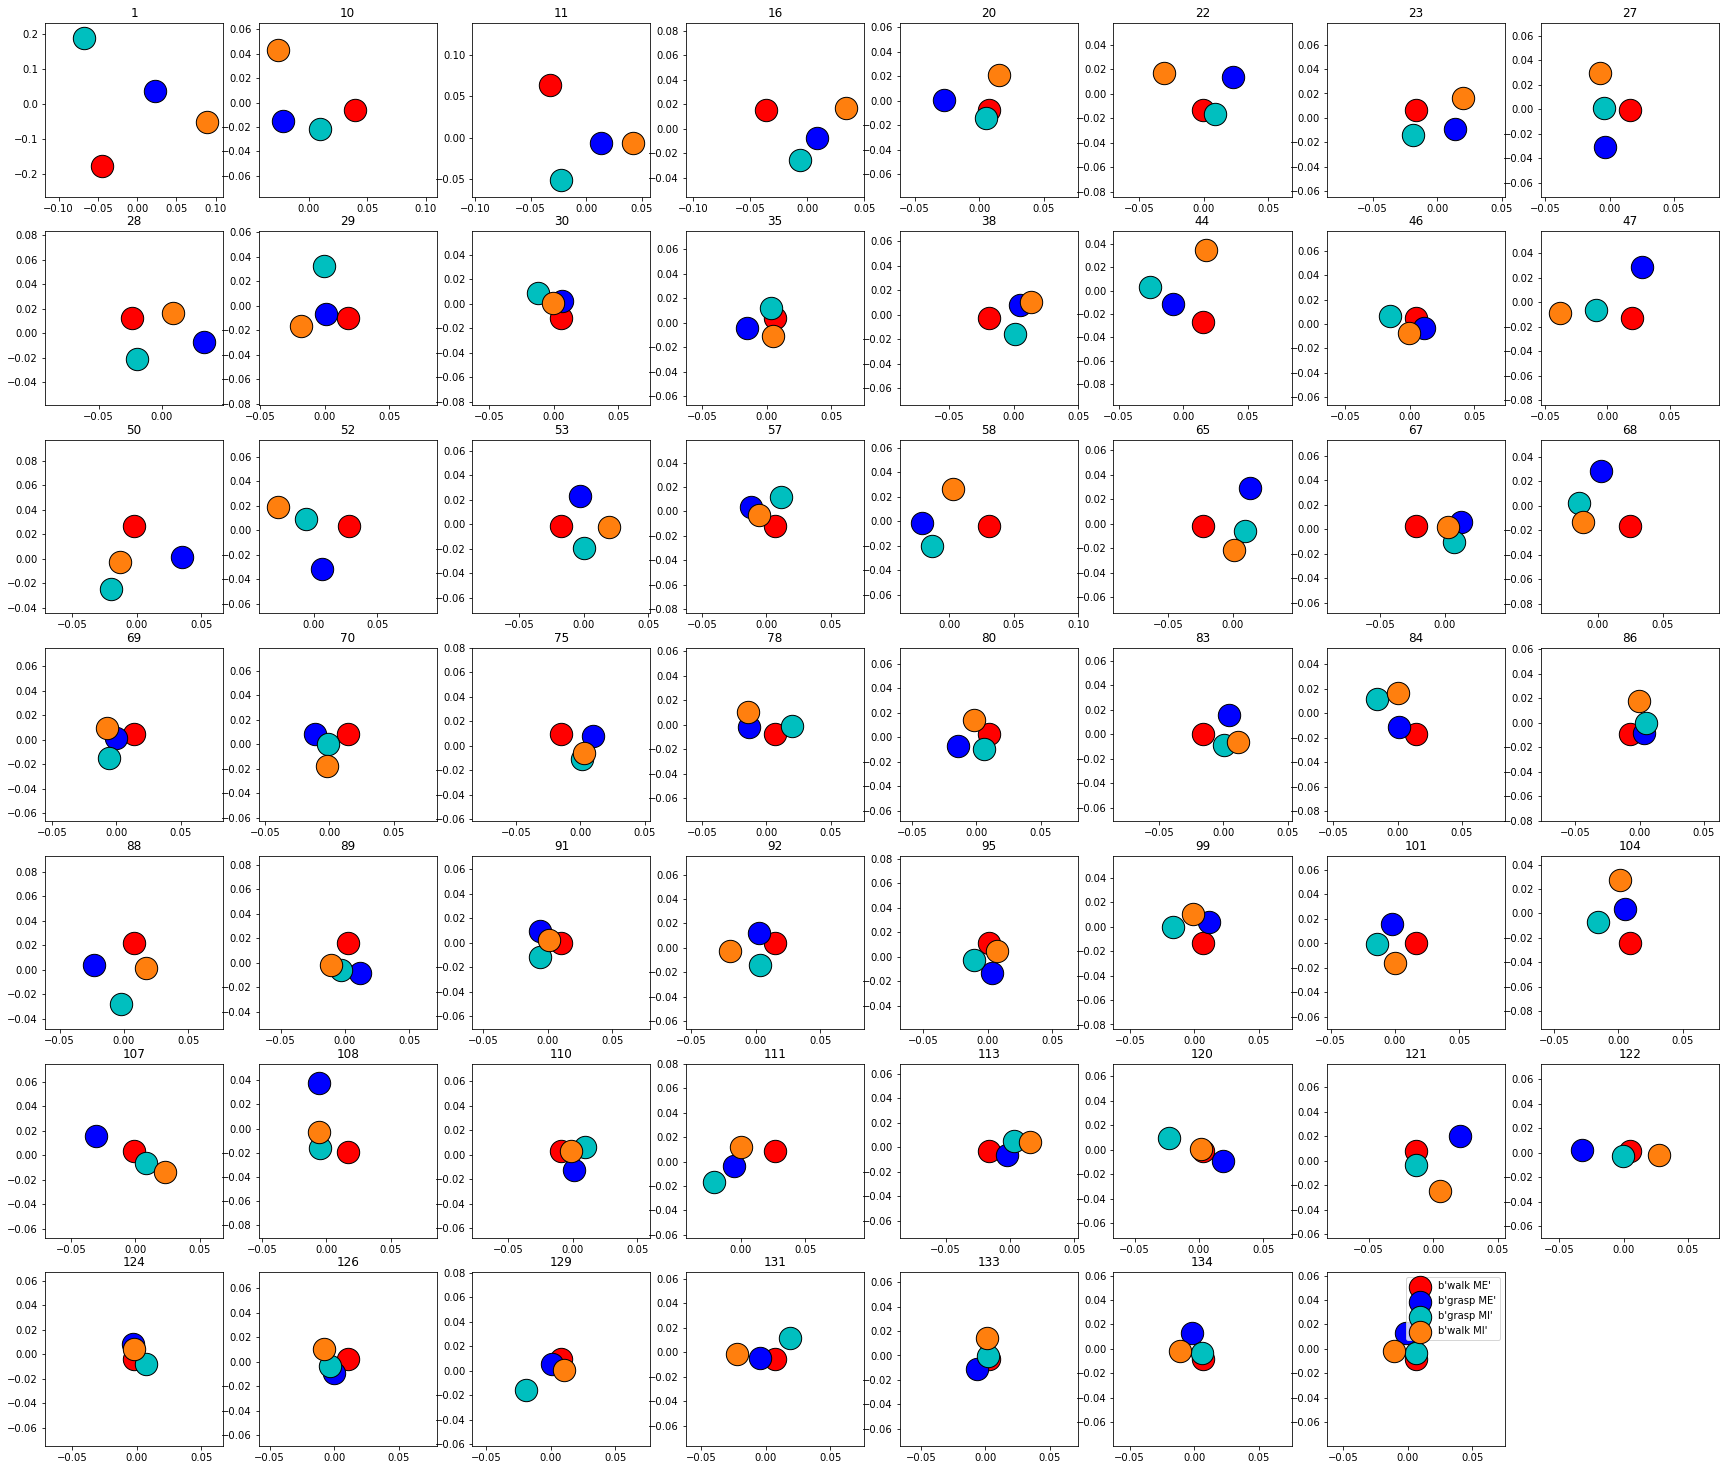

In [16]:
from sklearn.manifold import MDS
from math import sqrt
ncompmds = 2
mymds = MDS(dissimilarity='precomputed',n_components=ncompmds)

colors = ['r', 'b','c','tab:orange']
names = sorted(labels)
names =[w.replace(b'imp', b'walk ME') for w in names]
names =[w.replace(b'mboug', b'grasp ME') for w in names]
names =[w.replace(b'mimag', b'grasp MI') for w in names]
names =[w.replace(b'pimag', b'walk MI') for w in names]
size=500
nsub=int(sqrt(54))
fig=plt.figure(figsize=(30,30))
for nroi in range(54) : #range(184):
    mds_res = mymds.fit_transform(RDM_matrices_reduced_grav[nroi])
    ax = fig.add_subplot(nsub+1, nsub+1, nroi+1) # this line adds sub-axes
    for i,color in enumerate(colors):
        name=names[i]        
        ax.scatter(mds_res[i, 0], mds_res[i, 1], s=size,
               facecolors=color, label=name, edgecolors='k',)
    ax.set_title(str(motor_region[nroi]))
ax = fig.add_subplot(nsub+1, nsub+1, nroi+2) # this line adds sub-axes
for i,color in enumerate(colors):
        name=names[i]        
        ax.scatter(mds_res[i, 0], mds_res[i, 1], s=size,
               facecolors=color, label=name, edgecolors='k',)
        
ax.legend()

fig.savefig('Z:/GitHub/irm_marche/result_rsa_pca.png')


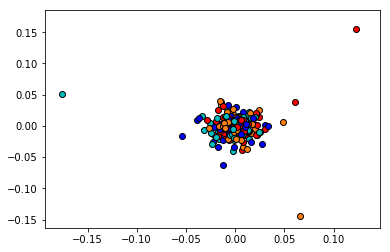

In [37]:
plt.figure()
for nroi in range(54):
    mds_res = mymds.fit_transform(RDM_matrices_reduced_grav[nroi])
    for i,color in enumerate(colors):
        name=names[i]
        plt.scatter(mds_res[i, 0], mds_res[i, 1], 
               facecolors=color, label=name, edgecolors='k',)

In [130]:
from networkx.convert_matrix import from_numpy_matrix

In [132]:
G = from_numpy_matrix(RDM_matrices_reduced_grav.mean(axis=0))

In [133]:
posdict = G.node_dict_factory({0:mds_res[0],1:mds_res[1],2:mds_res[2],3:mds_res[3]})

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 

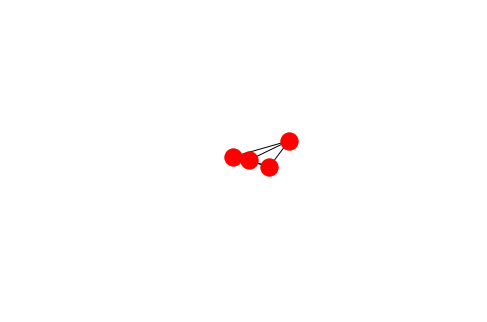

In [134]:
from networkx.drawing.nx_pylab import draw

draw(G,posdict)